In [1]:
print(__doc__)

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy  
from scipy import linalg

from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale  
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import style
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
import itertools

from sklearn import mixture


style.use("ggplot")
%matplotlib inline



Automatically created module for IPython interactive environment


In [2]:
def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)

In [3]:
raw_data = pd.read_csv('C:/Users/Chenming/Desktop/assignment3/Data1_Car/car.csv')
#convert buying to int, 'vhigh'->0, 'high'->1,'med'->2,'low'->3, save to a new dataset: data 
raw_data['buying'] = raw_data.buying.str.replace('vhigh','0')
raw_data['buying'] = raw_data.buying.str.replace('high','1')
raw_data['buying'] = raw_data.buying.str.replace('med','2')
raw_data['buying'] = raw_data.buying.str.replace('low','3')
data=raw_data
data['buying']=raw_data.buying
data['buying']=data.buying.astype(int)

In [4]:
#convert maint to int, 'vhigh'->0, 'high'->1,'med'->2,'low'->3, save to a new dataset: data 
raw_data['maint'] = raw_data.maint.str.replace('vhigh','0')
raw_data['maint'] = raw_data.maint.str.replace('high','1')
raw_data['maint'] = raw_data.maint.str.replace('med','2')
raw_data['maint'] = raw_data.maint.str.replace('low','3')
data['maint']=raw_data.maint
data['maint']=data.maint.astype(int)

In [5]:
#convert doors, 5more ->5, all to int
raw_data['doors'] = raw_data.doors.str.replace('5more','5')
data['doors']=raw_data.doors
data['doors']=data.doors.astype(int)

In [6]:
#persons more->5, all to int
raw_data['persons'] = raw_data.persons.str.replace('more','5')
data['persons']=raw_data.persons
data['persons']=data.persons.astype(int)

In [7]:
#lug_boot, small->0, med->1, big->2, all to int
raw_data['lug_boot'] = raw_data.lug_boot.str.replace('small','0')
raw_data['lug_boot'] = raw_data.lug_boot.str.replace('med','1')
raw_data['lug_boot'] = raw_data.lug_boot.str.replace('big','2')
data['lug_boot']=raw_data.lug_boot
data['lug_boot']=data.lug_boot.astype(int)

In [8]:
#safety, low->0, med->1, high->2
raw_data['safety'] = raw_data.safety.str.replace('low','0')
raw_data['safety'] = raw_data.safety.str.replace('med','1')
raw_data['safety'] = raw_data.safety.str.replace('high','2')
data['safety']=raw_data.safety
data['safety']=data.safety.astype(int)

In [9]:
#set label column
data['acceptable_label'] = raw_data.acceptable

In [10]:
#acceptable, unacc->0, acc->1, good->2, vgood->3
raw_data['acceptable'] = raw_data.acceptable.str.replace('unacc','0')
raw_data['acceptable'] = raw_data.acceptable.str.replace('acc','1')
raw_data['acceptable'] = raw_data.acceptable.str.replace('good','2')
raw_data['acceptable'] = raw_data.acceptable.str.replace('v2','3')
data['acceptable']=raw_data.acceptable
data['acceptable']=data.acceptable.astype(int)
data.head()

,buying,maint,doors,persons,lug_boot,safety,acceptable,acceptable_label
0,0,0,2,2,0,0,0,unacc
1,0,0,2,2,0,1,0,unacc
2,0,0,2,2,0,2,0,unacc
3,0,0,2,2,1,0,0,unacc
4,0,0,2,2,1,1,0,unacc


In [11]:
datalist_label = data.acceptable
datalist_names = data.acceptable_label
datalist_label_names = np.array(['unacc','acc','good','vgood'])
datalist = data.drop(['acceptable','acceptable_label'], axis=1)
datalist_array = datalist.values
datalist_array

array([[0, 0, 2, 2, 0, 0],
       [0, 0, 2, 2, 0, 1],
       [0, 0, 2, 2, 0, 2],
       ..., 
       [3, 3, 5, 5, 2, 0],
       [3, 3, 5, 5, 2, 1],
       [3, 3, 5, 5, 2, 2]])

In [12]:
EM_data = data.drop(['buying','maint','doors','persons','lug_boot','safety'], axis=1)

In [13]:
datalist_array

array([[0, 0, 2, 2, 0, 0],
       [0, 0, 2, 2, 0, 1],
       [0, 0, 2, 2, 0, 2],
       ..., 
       [3, 3, 5, 5, 2, 0],
       [3, 3, 5, 5, 2, 1],
       [3, 3, 5, 5, 2, 2]])

In [14]:
#Linear Discriminant Analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
X = datalist_array
y = datalist_label.values

In [15]:
for i in range(1,6):
    clf = LinearDiscriminantAnalysis(n_components=i, priors=None, shrinkage=None,
                  solver='eigen', store_covariance=False, tol=0.0001)
    data_LDA = clf.fit_transform(X, y)
    print ('component: ', i, ', Kurtosis: ', scipy.stats.kurtosis(data_LDA, fisher=False))

component:  1 , Kurtosis:  [ 2.54910251]
component:  2 , Kurtosis:  [ 2.54910251  2.54493771]
component:  3 , Kurtosis:  [ 2.54910251  2.54493771  2.45368186]
component:  4 , Kurtosis:  [ 2.54910251  2.54493771  2.45368186]
component:  5 , Kurtosis:  [ 2.54910251  2.54493771  2.45368186]


In [16]:
#NN  on X = datalist_array, y = datalist_label
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.cross_validation import StratifiedKFold
import time
from sklearn.neural_network import MLPClassifier

skf = StratifiedKFold(datalist_label, n_folds=4)
# Only take the first fold.
train_index, test_index = next(iter(skf))


X_train = datalist_array[train_index]
y_train = datalist_label[train_index].values
X_test  = datalist_array[test_index]
y_test  = datalist_label[test_index].values

C:\Users\Chenming\AppData\Roaming\Python\Python36\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [17]:
clf = LinearDiscriminantAnalysis(n_components=2, priors=None, shrinkage=None,
              solver='eigen', store_covariance=False, tol=0.0001)
clf.fit(X_train, y_train)
print ('train acc', clf.score(X_train, y_train))
print ('test acc', clf.score(X_test, y_test))

train acc 0.755795981453
test acc 0.709677419355


C:\Users\Chenming\AppData\Roaming\Python\Python36\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


In [18]:
#component = 2
clf = LinearDiscriminantAnalysis(n_components=2, priors=None, shrinkage=None,
                  solver='eigen', store_covariance=False, tol=0.0001)
data_LDA = clf.fit_transform(X, y)

In [19]:
#Try NN
#NN upon LDA dataset
from sklearn.metrics import explained_variance_score

X_train = data_LDA[train_index]
y_train = datalist_label[train_index].values
X_test  = data_LDA[test_index]
y_test  = datalist_label[test_index].values

start_time = time.time()

mlp = MLPClassifier(hidden_layer_sizes=(50,10), max_iter=1000, alpha=1e-4,
                    solver='sgd', verbose=10, tol=1e-4, random_state=1,
                    learning_rate_init=.03)

mlp.fit(X_train, y_train)
y_train_pred = mlp.predict(X_train)
y_test_pred = mlp.predict(X_test)
elapsed_time = time.time() - start_time

print("Training set score: %f" % mlp.score(X_train, y_train))
print ("Training variance: ", explained_variance_score(y_train, y_train_pred, multioutput='uniform_average'))
print("Test set score: %f" % mlp.score(X_test, y_test))
print ("Testing variance: ", explained_variance_score(y_test, y_test_pred, multioutput='uniform_average'))
print ("Running Time: ", elapsed_time)

Iteration 1, loss = 1.31178990
Iteration 2, loss = 0.90549747
Iteration 3, loss = 0.83018942
Iteration 4, loss = 0.74310564
Iteration 5, loss = 0.66951195
Iteration 6, loss = 0.60989368
Iteration 7, loss = 0.59279952
Iteration 8, loss = 0.66854273
Iteration 9, loss = 0.55030119
Iteration 10, loss = 0.47140007
Iteration 11, loss = 0.45370421
Iteration 12, loss = 0.49709070
Iteration 13, loss = 0.49017254
Iteration 14, loss = 0.43610490
Iteration 15, loss = 0.40654525
Iteration 16, loss = 0.38060028
Iteration 17, loss = 0.40257897
Iteration 18, loss = 0.36770138
Iteration 19, loss = 0.35824451
Iteration 20, loss = 0.33981178
Iteration 21, loss = 0.33991906
Iteration 22, loss = 0.32214702
Iteration 23, loss = 0.35913253
Iteration 24, loss = 0.45396773
Iteration 25, loss = 0.32836848
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Training set score: 0.865533
Training variance:  0.623934102142
Test set score: 0.813364
Testing variance:  0.51813843

In [20]:
#EM, Try GMMs with K=4
new_component=4
cv_type='spherical'
gmm = mixture.GaussianMixture(n_components=new_component,
                                      covariance_type=cv_type)
gmm.fit(data_LDA)
datalist_pred = gmm.predict(data_LDA)

EM_data['K4_LDA_label']=datalist_pred
K4_LDA_label = datalist_pred
K4_LDA_label

array([2, 2, 2, ..., 3, 0, 0], dtype=int64)

In [21]:
tb1 = pd.crosstab(EM_data['acceptable_label'],datalist_pred)
#data_label.head()
tb1

col_0,0,1,2,3
acceptable_label,,,,
acc,255,113,0,16
good,64,0,0,5
unacc,128,227,530,325
vgood,65,0,0,0


In [22]:
#EM assign test K=4 label
def em_K1_label(alpha):
    label_max = max(tb1.iloc[i,alpha] for i in range(4))
    if tb1.iloc[0,alpha] == label_max:
        return 'acc'
    if tb1.iloc[1,alpha] == label_max:
        return 'good'
    if tb1.iloc[2,alpha] == label_max:
        return 'unacc'
    if tb1.iloc[3,alpha] == label_max:
        return 'vgood'
EM_data['K4_LDA_label_name']=EM_data['K4_LDA_label'].apply(em_K1_label)
EM_data.head()

,acceptable,acceptable_label,K4_LDA_label,K4_LDA_label_name
0,0,unacc,2,unacc
1,0,unacc,2,unacc
2,0,unacc,2,unacc
3,0,unacc,2,unacc
4,0,unacc,2,unacc


In [23]:
K4_LDA_accuracy = len(EM_data[EM_data['acceptable_label']==EM_data['K4_LDA_label_name']])/len(EM_data)
print('K=4 LDA EM -> {0:.4f}%'.format(K4_LDA_accuracy*100))

K=4 LDA EM -> 77.3727%


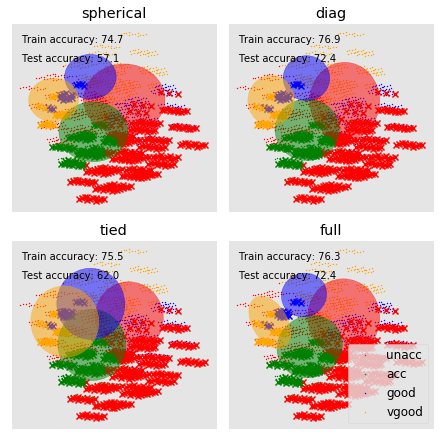

In [24]:
# Try GMMs using different types of covariances. K=4, iteration=200
n_classes=4
X_train = data_LDA[train_index]
y_train = datalist_label[train_index]
X_test  = data_LDA[test_index]
y_test  = datalist_label[test_index]
colors= ['red', 'green', 'blue', 'orange']
estimators = dict((cov_type, GaussianMixture(n_components=n_classes,
                   covariance_type=cov_type, max_iter=200, random_state=0))
                  for cov_type in ['spherical', 'diag', 'tied', 'full'])

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)
for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                    for i in range(n_classes)])

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = data_LDA[K4_LDA_label == n]
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color,
                    label=datalist_label_names[n])
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))


plt.show()

In [25]:
# EM K=14, full
new_component=14
cv_type='spherical'
gmm = mixture.GaussianMixture(n_components=new_component,
                                      covariance_type=cv_type)
gmm.fit(data_LDA)
datalist_pred = gmm.predict(data_LDA)

EM_data['K14_LDA_label']=datalist_pred
K14_LDA_label = datalist_pred

In [26]:
tb1 = pd.crosstab(EM_data['acceptable_label'],datalist_pred)
#data_label.head()
tb1

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12,13
acceptable_label,,,,,,,,,,,,,,
acc,0,35,59,0,10,18,10,0,105,0,0,0,132,15
good,0,0,0,0,51,0,0,0,0,0,0,0,0,18
unacc,107,204,3,162,3,127,85,76,9,77,94,161,26,76
vgood,0,0,14,0,47,0,0,0,0,0,0,0,4,0


In [27]:
#EM: assign test K=14 label

EM_data['K14_LDA_label_name']=EM_data['K14_LDA_label'].apply(em_K1_label)
EM_data.head()

,acceptable,acceptable_label,K4_LDA_label,K4_LDA_label_name,K14_LDA_label,K14_LDA_label_name
0,0,unacc,2,unacc,7,unacc
1,0,unacc,2,unacc,11,unacc
2,0,unacc,2,unacc,11,unacc
3,0,unacc,2,unacc,7,unacc
4,0,unacc,2,unacc,11,unacc


In [28]:
K14_LDA_accuracy = len(EM_data[EM_data['acceptable_label']==EM_data['K14_LDA_label_name']])/len(EM_data)
print('K=14 LDA EM -> {0:.4f}%'.format(K14_LDA_accuracy*100))

K=14 LDA EM -> 87.7315%


In [29]:
# EM K=40, diag
new_component=40
cv_type='spherical'
gmm = mixture.GaussianMixture(n_components=new_component,
                                      covariance_type=cv_type)
gmm.fit(data_LDA)
datalist_pred = gmm.predict(data_LDA)

EM_data['K40_LDA_label']=datalist_pred
K40_LDA_label = datalist_pred

In [30]:
tb1 = pd.crosstab(EM_data['acceptable_label'],datalist_pred)
#data_label.head()
tb1

col_0,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
acceptable_label,,,,,,,,,,,,,,,,,,,,,
acc,23,18,0,0,35,4,0,0,7,0,...,0,0,0,22,0,32,0,29,3,0
good,0,0,0,0,0,0,0,0,6,0,...,0,0,0,0,0,0,0,0,17,0
unacc,26,39,75,49,3,35,36,36,27,37,...,48,75,41,2,12,11,23,0,1,39
vgood,0,0,0,0,0,0,0,0,0,0,...,0,0,0,19,0,0,0,0,17,0


In [31]:
#EM: assign test K=40 label

EM_data['K40_LDA_label_name']=EM_data['K40_LDA_label'].apply(em_K1_label)
EM_data.head()

,acceptable,acceptable_label,K4_LDA_label,K4_LDA_label_name,K14_LDA_label,K14_LDA_label_name,K40_LDA_label,K40_LDA_label_name
0,0,unacc,2,unacc,7,unacc,34,unacc
1,0,unacc,2,unacc,11,unacc,28,unacc
2,0,unacc,2,unacc,11,unacc,32,unacc
3,0,unacc,2,unacc,7,unacc,34,unacc
4,0,unacc,2,unacc,11,unacc,28,unacc


In [32]:
K40_LDA_accuracy = len(EM_data[EM_data['acceptable_label']==EM_data['K40_LDA_label_name']])/len(EM_data)
print('K=40 LDA EM -> {0:.4f}%'.format(K40_LDA_accuracy*100))

K=40 LDA EM -> 87.5579%


In [58]:
#K-means
data_LDA_df = pd.DataFrame(data=data_LDA[0:,0:],
                   columns=['LDA1','LDA2'])
data_LDA_df['acceptable'] = datalist_label
data_LDA_df.to_csv('data_LDA_NN.csv' , sep=',')

data_LDA_df['acceptable_label'] = datalist_names
data_LDA_df.head()

,LDA1,LDA2,acceptable,acceptable_label
0,-1.049664,-0.667053,0,unacc
1,-1.811564,-1.076572,0,unacc
2,-2.573464,-1.486091,0,unacc
3,-1.289951,-0.634638,0,unacc
4,-2.051851,-1.044157,0,unacc


In [59]:
#EM treated for NN
#choose K14_LDA_label 

data_LDA_EM_NN_df = pd.DataFrame(data=data_LDA[0:,0:],
                   columns=['LDA1','LDA2'])
data_LDA_EM_NN_df['LDA14_label'] = EM_data['K14_LDA_label']
data_LDA_EM_NN_df.to_csv('data_LDA_EM.csv' , sep=',')
data_LDA_EM_NN=data_LDA_EM_NN_df.values

In [35]:
#NN upon PCA EM K=20 dataset
X_train = data_LDA_EM_NN[train_index]
y_train = datalist_label[train_index]
X_test  = data_LDA_EM_NN[test_index]
y_test  = datalist_label[test_index]

start_time = time.time()

mlp = MLPClassifier(hidden_layer_sizes=(50,10), max_iter=1000, alpha=1e-4,
                    solver='sgd', verbose=10, tol=1e-4, random_state=1,
                    learning_rate_init=.03)

mlp.fit(X_train, y_train)
y_train_pred = mlp.predict(X_train)
y_test_pred = mlp.predict(X_test)
elapsed_time = time.time() - start_time

print("Training set score: %f" % mlp.score(X_train, y_train))
print ("Training variance: ", explained_variance_score(y_train, y_train_pred, multioutput='uniform_average'))
print("Test set score: %f" % mlp.score(X_test, y_test))
print ("Testing variance: ", explained_variance_score(y_test, y_test_pred, multioutput='uniform_average'))
print ("Running Time: ", elapsed_time)

Iteration 1, loss = 1.44922975
Iteration 2, loss = 0.93286487
Iteration 3, loss = 0.87001469
Iteration 4, loss = 0.80104592
Iteration 5, loss = 0.78292717
Iteration 6, loss = 0.73359383
Iteration 7, loss = 0.67983162
Iteration 8, loss = 0.64756888
Iteration 9, loss = 0.61949389
Iteration 10, loss = 0.59610821
Iteration 11, loss = 0.61414892
Iteration 12, loss = 0.62589016
Iteration 13, loss = 0.57603775
Iteration 14, loss = 0.51836928
Iteration 15, loss = 0.55538893
Iteration 16, loss = 0.57493902
Iteration 17, loss = 0.55201973
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Training set score: 0.801391
Training variance:  0.0820428336079
Test set score: 0.861751
Testing variance:  0.274273564848
Running Time:  0.14300823211669922


In [36]:
data_LDA_df.describe()

,LDA1,LDA2,acceptable
count,1728.000000,1728.000000,1728.000000
mean,-3.750699,0.212151,0.414931
std,0.969001,1.087492,0.740700
min,-6.303141,-2.486670,0.000000
25%,-4.456032,-0.545092,0.000000
50%,-3.759164,0.215813,0.000000
75%,-3.074167,0.981028,1.000000
max,-1.049664,3.016106,3.000000


In [37]:
data_LDA_df.pivot_table(index='acceptable_label', values=['LDA1','LDA2'],aggfunc=np.mean)

,LDA1,LDA2
acceptable_label,,
acc,-4.597339,-0.161778
good,-5.110590,1.185473
unacc,-3.306104,0.251993
vgood,-5.581739,0.646306


In [38]:
d_corr_LDA1=data_LDA_df.iloc[:,[0,1,2]].corr()
d_corr_LDA1


,LDA1,LDA2,acceptable
LDA1,1.000000e+00,4.402143e-16,-0.701737
LDA2,4.402143e-16,1.000000e+00,0.054194
acceptable,-7.017373e-01,5.419441e-02,1.000000


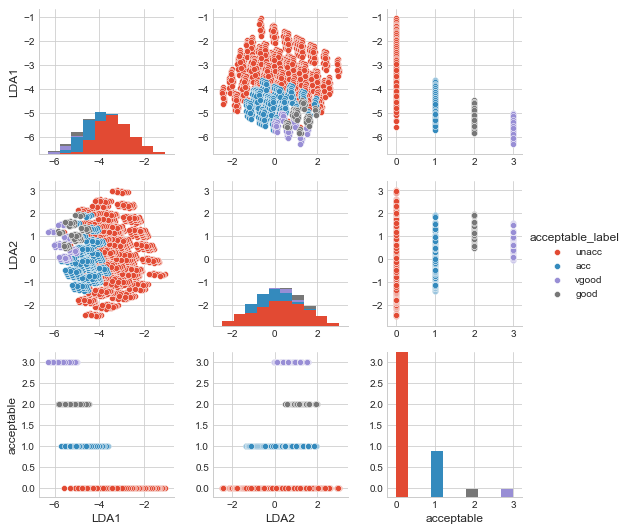

In [39]:
sns.set_style('whitegrid')
sns.pairplot(data_LDA_df.iloc[:,[0,1,2,3]], hue='acceptable_label')
plt.show()

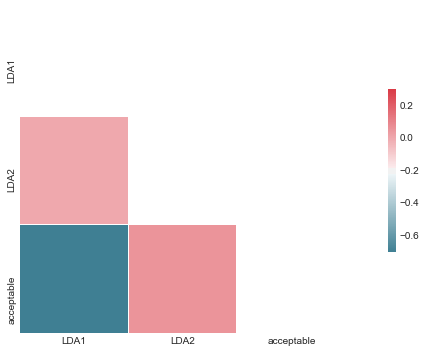

In [40]:
sns.set_style('whitegrid')
plt.figure(figsize=(15,6))
mask = np.zeros_like(d_corr_LDA1, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(d_corr_LDA1,mask=mask, cmap=cmap, vmax=.3,
            square=True,
            linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

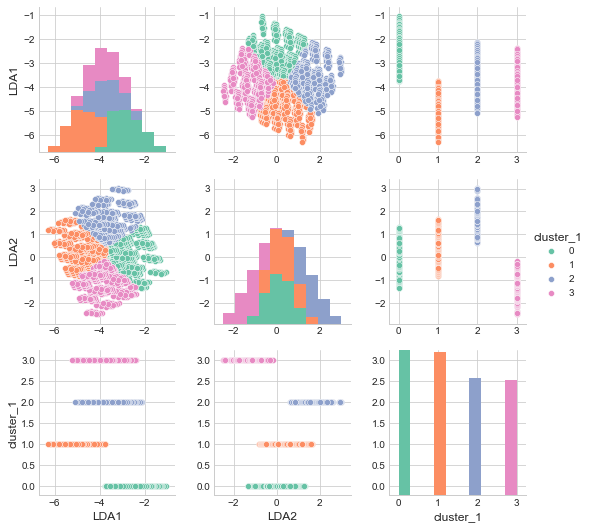

In [41]:
#K=4 K-means
kmeans_model_1 = KMeans(n_clusters=4,random_state=123)
distances_1 = kmeans_model_1.fit_transform(data_LDA_df.iloc[:,0:2])
labels_1 = kmeans_model_1.labels_
data_LDA_df['cluster_1']=labels_1
with sns.color_palette("Set2", 10):
    sns.pairplot(data_LDA_df.iloc[:,[0,1,4]], hue='cluster_1')

In [42]:
#statistics of acceptable_label cluster_1 vs species
tb1 = pd.crosstab(data_LDA_df['acceptable_label'],labels_1)
tb1

col_0,0,1,2,3
acceptable_label,,,,
acc,0,250,22,112
good,0,57,12,0
unacc,480,104,356,270
vgood,0,65,0,0


In [43]:
#cluster_1_label
def cluster_1_label(alpha):
    label_max = max(tb1.iloc[i,alpha] for i in range(4))
    if tb1.iloc[0,alpha] == label_max:
        return 'acc'
    if tb1.iloc[1,alpha] == label_max:
        return 'good'
    if tb1.iloc[2,alpha] == label_max:
        return 'unacc'
    if tb1.iloc[3,alpha] == label_max:
        return 'vgood'
data_LDA_df['cluster_1_label']=data_LDA_df['cluster_1'].apply(cluster_1_label)
data_LDA_df.head()

,LDA1,LDA2,acceptable,acceptable_label,cluster_1,cluster_1_label
0,-1.049664,-0.667053,0,unacc,0,unacc
1,-1.811564,-1.076572,0,unacc,0,unacc
2,-2.573464,-1.486091,0,unacc,3,unacc
3,-1.289951,-0.634638,0,unacc,0,unacc
4,-2.051851,-1.044157,0,unacc,0,unacc


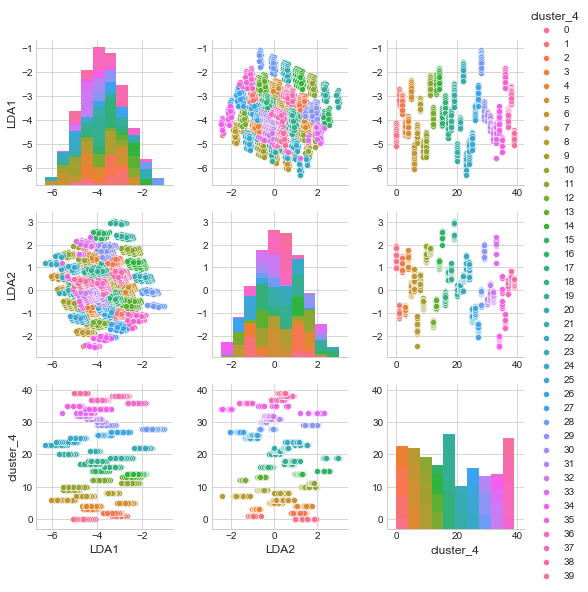

In [44]:
#K=40
kmeans_model_4 = KMeans(n_clusters=40,random_state=123)
distances_4 = kmeans_model_4.fit_transform(data_LDA_df.iloc[:,0:3])
labels_4 = kmeans_model_4.labels_
data_LDA_df['cluster_4']=labels_4
with sns.color_palette("Set2", 10):
    sns.pairplot(data_LDA_df.iloc[:,[0,1,6]], hue='cluster_4')

In [45]:
#compare labels K=40
tb4 = pd.crosstab(data_LDA_df['acceptable_label'],labels_4)
tb4

col_0,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
acceptable_label,,,,,,,,,,,,,,,,,,,,,
acc,27,0,0,51,0,0,0,0,0,47,...,18,0,67,0,0,0,0,0,0,48
good,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
unacc,0,54,73,0,52,66,0,34,64,0,...,0,29,0,28,31,9,28,85,65,0
vgood,0,0,0,0,0,0,48,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
#cluster_4_label
def cluster_4_label(alpha):
    label_max = max(tb4.iloc[i,alpha] for i in range(4))
    if tb4.iloc[0,alpha] == label_max:
        return 'acc'
    if tb4.iloc[1,alpha] == label_max:
        return 'good'
    if tb4.iloc[2,alpha] == label_max:
        return 'unacc'
    if tb4.iloc[3,alpha] == label_max:
        return 'vgood'
data_LDA_df['cluster_4_label']=data_LDA_df['cluster_4'].apply(cluster_4_label)
data_LDA_df.head()

,LDA1,LDA2,acceptable,acceptable_label,cluster_1,cluster_1_label,cluster_4,cluster_4_label
0,-1.049664,-0.667053,0,unacc,0,unacc,28,unacc
1,-1.811564,-1.076572,0,unacc,0,unacc,36,unacc
2,-2.573464,-1.486091,0,unacc,3,unacc,36,unacc
3,-1.289951,-0.634638,0,unacc,0,unacc,28,unacc
4,-2.051851,-1.044157,0,unacc,0,unacc,36,unacc


In [47]:
#find center of K=4
centroids_LDA1 = kmeans_model_1.cluster_centers_
print (centroids_LDA1)

[[-2.75864506  0.11030334]
 [-4.76071733  0.30666234]
 [-3.64623383  1.59570079]
 [-3.84535491 -1.19016769]]


In [48]:
#find center of K=40
centroids_LDA4 = kmeans_model_4.cluster_centers_

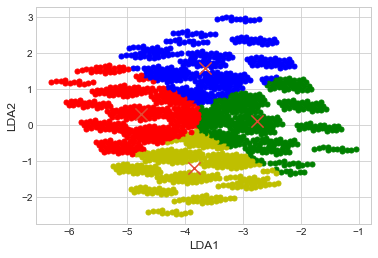

In [49]:
#RP K=4, upon cluster_1
colors = ["g.", "r.", "b.", "y."]
for i in range(len(data_LDA_df)):
    plt.plot(data_LDA_df.iloc[i,0],data_LDA_df.iloc[i,1], colors[data_LDA_df.iloc[i,4]], markersize = 10)    
plt.scatter(centroids_LDA1[:,0], centroids_LDA1[:,1],marker="x", s=150, linewidths =5, zorder=10)
plt.xlabel('LDA1')
plt.ylabel('LDA2')
plt.show()


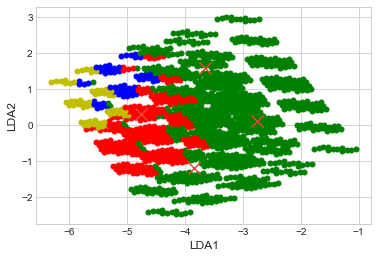

In [50]:
#RP K=4 upon original label
colors = ["g.", "r.", "b.", "y."]
for i in range(len(data_LDA_df)):
    plt.plot(data_LDA_df.iloc[i,0],data_LDA_df.iloc[i,1], colors[data_LDA_df.iloc[i,2]], markersize = 10)    
plt.scatter(centroids_LDA1[:,0], centroids_LDA1[:,1],marker="x", s=150, linewidths =5, zorder=10)
plt.xlabel('LDA1')
plt.ylabel('LDA2')
plt.show()


In [51]:
data_LDA_df.head()

,LDA1,LDA2,acceptable,acceptable_label,cluster_1,cluster_1_label,cluster_4,cluster_4_label
0,-1.049664,-0.667053,0,unacc,0,unacc,28,unacc
1,-1.811564,-1.076572,0,unacc,0,unacc,36,unacc
2,-2.573464,-1.486091,0,unacc,3,unacc,36,unacc
3,-1.289951,-0.634638,0,unacc,0,unacc,28,unacc
4,-2.051851,-1.044157,0,unacc,0,unacc,36,unacc


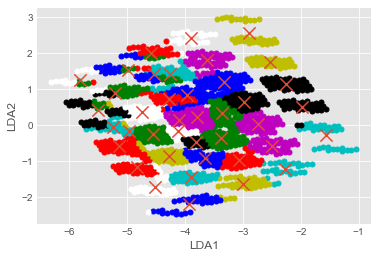

In [62]:
#RP K=40 upon cluster_4
style.use("ggplot")
colors = ["g.", "r.", "b.", "y.", "c.", "m.", "k.", "w.",
          "g.", "r.", "b.", "y.", "c.", "m.", "k.", "w.",
          "g.", "r.", "b.", "y.", "c.", "m.", "k.", "w.",
          "g.", "r.", "b.", "y.", "c.", "m.", "k.", "w.",
          "g.", "r.", "b.", "y.", "c.", "m.", "k.", "w."]
for i in range(len(data_LDA_df)):
    plt.plot(data_LDA_df.iloc[i,0],data_LDA_df.iloc[i,1], colors[data_LDA_df.iloc[i,6]], markersize = 10)    
plt.scatter(centroids_LDA4[:,0], centroids_LDA4[:,1],marker="x", s=150, linewidths =5, zorder=10)
plt.xlabel('LDA1')
plt.ylabel('LDA2')
plt.show()

In [52]:
d_corr_LDA1=data_LDA_df.iloc[:,[0,1,4]].corr()
d_corr_LDA1
#Correlation K=4 for dataset after RP

,LDA1,LDA2,cluster_1
LDA1,1.000000e+00,4.402143e-16,-0.272885
LDA2,4.402143e-16,1.000000e+00,-0.231246
cluster_1,-2.728850e-01,-2.312462e-01,1.000000


In [53]:
d_corr_LDA4=data_LDA_df.iloc[:,[0,1,6]].corr()
d_corr_LDA4
#lug_boot and persons

,LDA1,LDA2,cluster_4
LDA1,1.000000e+00,4.402143e-16,-0.006738
LDA2,4.402143e-16,1.000000e+00,-0.068805
cluster_4,-6.738323e-03,-6.880538e-02,1.000000


In [54]:
cluster_1_accuracy = len(data_LDA_df[data_LDA_df['acceptable_label']==data_LDA_df['cluster_1_label']])/len(data_LDA_df)
cluster_4_accuracy = len(data_LDA_df[data_LDA_df['acceptable_label']==data_LDA_df['cluster_4_label']])/len(data_LDA_df)
print('K=4 KMeans -> {0:.4f}%'.format(cluster_1_accuracy*100))
print('K=40 KMeans -> {0:.4f}%'.format(cluster_4_accuracy*100))

K=4 KMeans -> 78.4722%
K=40 KMeans -> 100.0000%


In [55]:
data_LDA_df.describe()

,LDA1,LDA2,acceptable,cluster_1,cluster_4
count,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000
mean,-3.750699,0.212151,0.414931,1.390046,18.622685
std,0.969001,1.087492,0.740700,1.111895,11.987544
min,-6.303141,-2.486670,0.000000,0.000000,0.000000
25%,-4.456032,-0.545092,0.000000,0.000000,8.000000
50%,-3.759164,0.215813,0.000000,1.000000,18.000000
75%,-3.074167,0.981028,1.000000,2.000000,29.000000
max,-1.049664,3.016106,3.000000,3.000000,39.000000


In [57]:
data_LDA_KM_NN_df = pd.DataFrame(data=data_LDA[0:,0:],
                   columns=['LDA1','LDA2'])
data_LDA_KM_NN_df['K40_label'] = data_LDA_df['cluster_4']
data_LDA_KM_NN_df.to_csv('data_LDA_KM.csv' , sep=',')